In [157]:
# @title Autor: Alan Echer
# O algoritmo abaixo foi criado baseado nas funcoes apreendidas na aula de
# IA e machine learning do INFNET

# passos para fazer ao analisar os dados
#adicionar dependencias
#carregar os dados dos dataset
#analisar de dados
#normalizar dados das colunas
#verificar dados nullos
#verificar dados categoricos
#verificar representatividade dos dados do objetivo em relação ao restante dos dados
#(objetivo = 1, restante = 0)
#normalizar os dados
#verificar separabilidade linear
#separar os dados treino / teste estratificando
#definir o baseline otimista / pessimista
#gerar os dados estatisticos
#otimizacao verificar os falsos positivos e falsos negativos em funcao do limiar minimo
#otimizacao verificar o precisao e recall em funcao do limiar minimo
#otimizacao verificar curva ROC vs classificador aleatorio
#otimizacao lucro medio em relacao ao limiar minimo
#gerar o modelo e os dados estatisticos
#comparar com os modelos otimista e pessimistas

In [158]:
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import matplotlib.colors as colors
# para normalizacao - MinMaxScaler
# para padronizacao normal - StandardScaler
# para padronizacao robusta - RobustScaler
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from google.colab import drive

# ignorar warnings
warnings.filterwarnings('ignore')

In [159]:
# o codigo abaixo sao todas as funcoes utilizadas pelo algoritmo para tratar e analisar os dados, nao devem ser alteradas

def loadAnaliseAndTransformData(cache, configuration, y_column):
  data = loadDataSetFromGDriveOrCache(cache, configuration)

  reAddDroppedColumnsBefore(configuration, cache, data)

  if(configuration['normalize_columns']['enabled']):
    print()
    print('=> Normalizing column names...')
    normalizeColumnNames(configuration, data)
    print('=> Normalizing column names... OK')

  if(configuration['drop_rows_by_value']['enabled']):
    print()
    print('=> Dropping rows by value...')
    dropRowsByValue(configuration, data)
    print('=> Dropping rows by value... OK')

  transformData(configuration, cache, data)

  if(configuration['drop_columns']['enabled']):
    print()
    print('=> Dropping columns...')
    dropColumns(configuration, cache, data)
    print('=> Dropping columns... OK')

  if(configuration['drop_not_a_number_rows']['enabled']):
    print()
    print('=> Dropping not a number rows...')
    data.dropna(inplace=True)
    print('=> Dropping not a number rows... OK')

  if(configuration['drop_duplicated_rows']['enabled']):
    print()
    print('=> Dropping duplicated rows...')
    data.drop_duplicates(inplace=True, keep=configuration['drop_duplicated_rows']['keep'])
    print('=> Dropping duplicated rows... OK')

  if(configuration['dataset']['show_data']['enabled']):
    showDataInfo(configuration, data)

  if(data.get(y_column) is None):
    print('=> ERROR: Y column not found on dataset: ', y_column)
    print('=> ERROR: ABORTING...OK')
    return

  if(configuration['pair_plot']['enabled']):
    print()
    print('=> Plotting pair plot...')
    plotPairPlot(configuration, data)
    print('=> Plotting pair plot... OK')

  if(configuration['proportion_plot']['enabled']):
    print()
    print('=> Plotting proportions...')
    proportionPlot(configuration, data)
    print('=> Plotting proportions... OK')

  if(configuration['prediction_models']['enabled']):
    print()
    print('=> Running models...')
    runModels(configuration, data, y_column)
    print('=> Running models... OK')

  return data

def dropRowsByValue(configuration, data):
  for rule in configuration['drop_rows_by_value']['rules']:
    if(not rule['enabled']):
      continue
    column = rule['column']
    value_to_drop = rule['value_to_drop']
    print('=> Shape before dropping rows: ', data.shape)
    print('=> Using column: ', column, ' and value: ', value_to_drop)
    data.drop(data.index[(data[column] == value_to_drop)],axis=0,inplace=True)
    print('=> Shape after dropping rows: ', data.shape)


def loadDataSetFromGDriveOrCache(cache, configuration):
  if(cache['dataset'] is None):
    if(configuration['dataset']['source_provider'] == 'gdrive'):
      print('=> Mounting google drive...')
      drive.mount('/content/drive')
      print('=> Mounting google drive... OK')
    else:
      print('=> ERROR: Source provider not supported: '+configuration['dataset']['source_provider'])
      return

    if(configuration['dataset']['reader_type'] == 'csv'):
      print('=> Reading csv data...')
      cache['dataset'] = pd.read_csv('/content/drive/MyDrive/'+configuration['dataset']['path'], sep=configuration['dataset']['sep'])
      print('=> Reading csv data... OK')
      return cache['dataset']
    else:
      print('=> ERROR: Reader type not supported: '+configuration['dataset']['reader_type'])
      return
  else:
    print()
    print('=> Using cached dataset... OK')
  return cache['dataset']

def showDataInfo(configuration, data):
  if(configuration['dataset']['show_data']['dataset_print_mean_std']['enabled']):
    print()
    print('=> Dataset mean and std: ')
    for column in configuration['dataset']['show_data']['dataset_print_mean_std']['coluns']:
      print('=> Column: ', column, ' - mean: ', round(data[column].values.mean(), 2), ' - std: ', round(data[column].values.std(), 2))

  if(configuration['dataset']['show_data']['dataset_head']):
    print()
    print('=> Dataset head: ')
    print(data.head())

  if(configuration['dataset']['show_data']['dataset_info']):
    print()
    print('=> Dataset info: ')
    print(data.info())

  if(configuration['dataset']['show_data']['dataset_describe']):
    print()
    print('=> Dataset describe: ')
    print(data.describe())

  if(configuration['dataset']['show_data']['dataset_nulls']):
    print()
    print('=> Dataset nulls: ')
    print(data.isnull().sum())

  if(configuration['dataset']['show_data']['dataset_duplicated']):
    print()
    print('=> Dataset duplicated: ')
    print(data.duplicated().sum())

  if(configuration['dataset']['show_data']['dataset_unique_values']):
    print()
    print('=> Dataset unique values: ')
    for column in data.columns:
      print()
      print('=> Column: '+column, data[column].unique())

  if(configuration['dataset']['show_data']['dataset_value_counts']):
    print()
    print('=> Dataset value counts: ')
    for column in data.columns:
      print()
      print('=> Column: ', data[column].value_counts(normalize=True))
  pass

def transformData(configuration, cache, data):
  for transformation in configuration['data_transformation']['transformations']:
    columnName = transformation['column']
    #backup original data column for cenarios where you need to run transformation multiple times
    #and not want to loose original data
    cachedColumns = cache['original_data_before_transformation']
    if(not transformation['enabled']):
      if(cachedColumns.get(columnName) is not None):
        data[columnName] = cachedColumns[columnName]
      continue
    print()
    print('=> Applying data transformations...')
    if(cachedColumns.get(columnName) is None):
      cachedColumns[columnName] = data[columnName]
    if(transformation['transform_to_new_column']['enabled']):
      data[transformation['transform_to_new_column']['name']] = data[columnName].apply(transformation['function'])
    else:
      data[columnName] = cachedColumns[columnName].apply(transformation['function'])
    print('=> Applying data transformations... OK')
  pass

def normalizeColumnNames(configuration, data):
  normalize = configuration['normalize_columns']
  if(normalize['modificator'] == 'lower'):
    data.columns = data.columns.str.lower()
  elif(normalize['modificator'] == 'upper'):
    data.columns = data.columns.str.upper()
  else:
    print('=> ERROR: modificator unsuported!')
  for column in data.columns:
    for replacement in normalize['replacements']:
      data.columns = data.columns.str.replace(replacement['char_to_replace'], replacement['replace_with'])
  pass

def reAddDroppedColumnsBefore(configuration, cache, data):
  columns = []
  for column in cache['original_data_before_drop']:
    if(cache['original_data_before_drop'].get(column) is not None):
      print()
      print('=> Recriando coluna previamente deletada: ', column)
      data[column] = cache['original_data_before_drop'][column]
      columns.append(column)
      print('=> Recriando coluna previamente deletada... OK')
  for column in columns:
     print()
     print('=> Apagando coluna restaurada do cache: ', column)
     del cache['original_data_before_drop'][column]
     print('=> Apagando coluna restaurada do cache... OK')
  pass

def dropColumns(configuration, cache, data):
  for column in configuration['drop_columns']['columns']:
    cache['original_data_before_drop'][column] = data[column]
  return data.drop(columns=configuration['drop_columns']['columns'], inplace=True)

def checkColumnTypesAreNumbers(data, columns):
  invalidColumns=[]
  for column in columns:
    for value in data[column].unique():
      try:
        float(value)
      except ValueError:
        print()
        print('=> ERROR: this column cannot be used to pair plot because it not have numerical values: ', column)
        print('=> ERROR: value: ', value)
        invalidColumns.append(column)
        break
  for column in invalidColumns:
    print()
    print('=> Removing invalid column for pair plot: ', column)
    columns.remove(column)
  pass

def plotPairPlot(configuration, data):
  if(configuration['pair_plot']['type'] == '2d'):
    hue = hue=configuration['pair_plot']['hue_column']
    if(configuration['pair_plot']['columns'] == 'all'):
      columns = []
      for column in data.columns:
        columns.append(column)
      print()
      print('=> Plotting pair plot with all columns: ', columns)
      checkColumnTypesAreNumbers(data, columns)
      sns.pairplot(data=data, hue=hue)
    elif (configuration['pair_plot']['columns'] == 'selection'):
      selection = configuration['pair_plot']['selection']
      if(hue not in selection):
        selection.append(hue)
      checkColumnTypesAreNumbers(data, selection)
      data_to_plot = data.loc[:,selection]
      print()
      print('=> Plotting pair plot with columns: ', selection)
      sns.pairplot(data=data_to_plot, hue=hue)
    else:
      print('=> ERROR: Pair plot columns not supported: '+configuration['pair_plot']['columns'])
      return
  else:
    print('=> ERROR: Pair plot type not supported: '+configuration['pair_plot']['type'])
    return
  pass

def runModels(configuration, data, y_column):
  unique_values = data[y_column].unique()
  if(len(unique_values) == 2):
    if((unique_values[0] == 1 or unique_values[0] == 0) and (unique_values[1] == 1 or unique_values[1] == 0)):

      proportion = configuration['dataset']['proportion_of_test']
      x = data.drop(columns=[y_column])
      y = data[[y_column]]
      x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=proportion, stratify=y, random_state=random_state)

      roc_curve_list = []
      roc_curve_list.append({'fpr':[0, 1], 'tpr':[0, 1], 'label':'ROC Curve - Random Classifier'})

      for algoritm in configuration['prediction_models']['algoritms']:
        if(not algoritm['enabled']):
          continue

        pipeline = algoritm['pipeline']

        print('=> Running model: ', algoritm['name'])

        pipeline.fit(x_train, y_train)
        y_predicted_test = pipeline.predict(x_test)
        y_predicted_train = pipeline.predict(x_train)

        model = pipeline.named_steps['model']

        fine_tuning = algoritm['fine_tuning']

        if(not fine_tuning['enabled']):
          if(algoritm['metrics']['enabled']):
            printScore(algoritm['metrics'], y_train, y_test, y_predicted_train, y_predicted_test)
            printGraphics(algoritm['metrics'], x_train, y_train, y_test, y_predicted_train, y_predicted_test, model)
        else:
          splitter = StratifiedKFold(n_splits=fine_tuning['stratifykfold_splits'], shuffle=True, random_state=random_state)

          if(fine_tuning['grid_search_cv']['enabled']):
            search = GridSearchCV(
              estimator=pipeline,
              param_grid=fine_tuning['grid_search_cv']['hyperparam'],
              scoring=fine_tuning['grid_search_cv']['scoring'],
              cv=splitter,
              refit=True,
              error_score=0,
              verbose=0)
            search.fit(x_train, y_train)

            y_best_train = search.best_estimator_.predict(x_train)
            y_best_test = search.best_estimator_.predict(x_test)

            if(algoritm['metrics']['enabled']):
              print('=> Best params grid search cv: ', search.best_params_)
              print('=> Best score grid search cv: ', search.best_score_)
              print('=> Using best estimator to print metrics...')
              printScore(algoritm['metrics'], y_train, y_test, y_best_train, y_best_test)
              printGraphics(algoritm['metrics'], x_train, y_train, y_test, y_best_train, y_best_test, model)

          else:
            print('=> ERROR: Fine tuning only supports grid search cv')
            return

        if(algoritm['metrics']['plot_roc_curve']):
              fpr, tpr = calcRocCurve(pipeline, x_test, y_test)
              roc_curve_list.append({'fpr':fpr, 'tpr':tpr, 'label':'ROC Curve - '+algoritm['name']})

      if(roc_curve_list):
        printRocCurve(roc_curve_list)
    else:
      print('=> ERROR: Y column has following values: ', unique_values)
      print('=> ERROR: Y column must contain only two values: 0, 1')
  else:
    print('=> ERROR: Y column has following values: ', unique_values)
    print('=> ERROR: Y column must contain only two values: 0, 1')
  pass

def printScore(metrics, y_train, y_test, y_predicted_train, y_predicted_test):
  if(metrics['print_metrics']):
    printScoreReport(y_train, y_predicted_train, 'Treino')
    printScoreReport(y_test, y_predicted_test, 'Teste')

def printGraphics(metrics, x_train, y_train, y_test, y_predicted_train, y_predicted_test, model):
  if(metrics['plot_confusion_matrix']):
    print('=> Printing confusion matrix - Treino')
    printConfusionMatrix(y_train, y_predicted_train)
    print('=> Printing confusion matrix - Teste')
    printConfusionMatrix(y_test, y_predicted_test)
  if(metrics['plot_tree']):
    print('=> Printing Tree')
    plt.figure(figsize=(100,50))
    plot_tree(model, feature_names=x_train.columns, filled=True)
    plt.show()
    print('=> Tree deeph', model.get_depth())
    print('=> Tree leaf: ', model.get_n_leaves())


def printScoreReport(y_train, y_predicted, label):
  print('=> Printing model metrics - ', label)
  accuracy = accuracy_score(y_train, y_predicted)
  precision = precision_score(y_train, y_predicted)
  recall = recall_score(y_train, y_predicted)
  f1 = f1_score(y_train, y_predicted)
  #TODO - jogar no config: {‘micro’, ‘macro’, ‘samples’, ‘weighted’, ‘binary’}
  precision_weighted = precision_score(y_train, y_predicted, average='weighted')
  recall_weighted = recall_score(y_train, y_predicted, average='weighted')
  f1_weighted = f1_score(y_train, y_predicted, average='weighted')
  print('=> Accuracy: ', round(accuracy, 2))
  print('=> Precision: ', round(precision, 2))
  print('=> Recall: ', round(recall, 2))
  print('=> F1: ', round(f1, 2))
  print('=> Precision weighted: ', round(precision_weighted, 2))
  print('=> Recall weighted: ', round(recall_weighted, 2))
  print('=> F1 weighted: ', round(f1_weighted, 2))
  print(classification_report(y_train, y_predicted))
  pass

def calcRocCurve(pipeline, x_test, y_test):
  prob_test = pipeline.predict_proba(x_test)
  fpr, tpr, _ = roc_curve(y_test, [c[1] for c in prob_test])
  return fpr, tpr

def printRocCurve(roc_courves):
  for roc_courve in roc_courves:
    plt.plot(roc_courve['fpr'], roc_courve['tpr'], label=roc_courve['label'])
  plt.legend()
  plt.xlabel('Taxa de Falsos Positivos')
  plt.ylabel('Taxa de Verdadeiros Positivos')
  plt.show()

def printTree(data, columns):
  plot_tree(data, feature_names=columns, filled=True)
  plt.show()
  pass

def printConfusionMatrix(data, y_optimist):
  print()
  cm = confusion_matrix(data[y_column], y_optimist)
  labels = np.array([["TN[{}]".format(cm[0,0]), "FP[{}]".format(cm[0,1])],
                   ["FN[{}]".format(cm[1,0]), "TP[{}]".format(cm[1,1])]])
  sns.heatmap(cm,  annot=labels, fmt='', cmap="Blues")
  plt.title('Confusion Matrix - Logistic Regression')
  plt.xlabel('Output Predicted by Model')
  plt.ylabel('Output Expected')
  plt.tight_layout()
  plt.show()
  pass

def proportionPlot(configuration, data):
  if(configuration['proportion_plot']['columns'] == 'all'):
    for column in data.columns:
      proportionPlotGraphic(data, configuration, column)
  elif (configuration['proportion_plot']['columns'] == 'selection'):
    for selection in configuration['proportion_plot']['selection']:
      if(selection['enabled']):
        proportionPlotGraphic(data, configuration, selection['column'])
  else:
    print('=> ERROR: Pair plot columns not supported: '+configuration['pair_plot']['columns'])
    return
  pass

def proportionPlotGraphic(data, configuration, column):
  print()
  print("=> Ploting proportion for column: ", column)
  proportions = data[column].value_counts(normalize=True)
  plt.bar(x=proportions.index, height=proportions.values)
  plt.title('Proporção de valores da coluna: '+column)
  plt.show()
  pass


In [160]:
# as variaveis abaixo mantem o cache de alguns dados antes das transformacoes,
# drops ou carregamento do gdrive para melhorias de performance e integridade
# das informacoes quando sao feitas execucoes de codigo parciais no colab
cache = {
    'dataset':None,
    'original_data_before_transformation':{},
    'original_data_before_drop':{},
}

=> Mounting google drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=> Mounting google drive... OK
=> Reading csv data...
=> Reading csv data... OK

=> Normalizing column names...
=> Normalizing column names... OK

=> Dropping rows by value...
=> Shape before dropping rows:  (6497, 13)
=> Using column:  type  and value:  red
=> Shape after dropping rows:  (4898, 13)
=> Dropping rows by value... OK

=> Applying data transformations...
=> Applying data transformations... OK

=> Dropping columns...
=> Dropping columns... OK

=> Dropping not a number rows...
=> Dropping not a number rows... OK

=> Dropping duplicated rows...
=> Dropping duplicated rows... OK

=> Dataset mean and std: 
=> Column:  fixed_acidity  - mean:  6.84  - std:  0.87
=> Column:  volatile_acidity  - mean:  0.28  - std:  0.1
=> Column:  citric_acid  - mean:  0.33  - std:  0.12
=> Column:  residual_sugar  - mean:  5.92  - std:  4.86


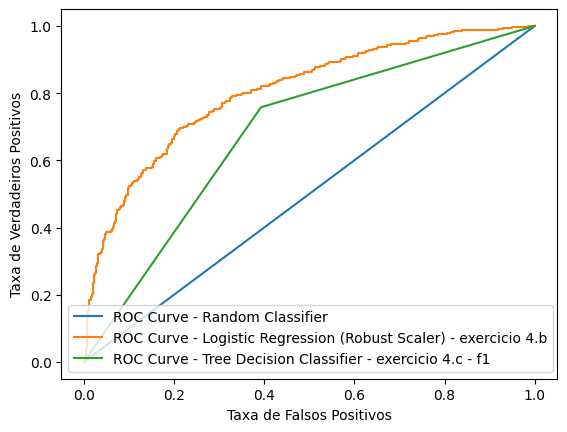

=> Running models... OK


In [161]:
# Esta é a configuracao inicial nela voce irá alterar as variaveis para que
# sua analise seja feita corretamente, nao se preocupe com a quantidade de
# informacao e nem no que será colocado em cada campo neste momento
# pois a maioria dos trechos estao desabilitados 'enabled': False entao nao
# serao executados.

# 1. Comece pela seção dataset, informando sua fonte de dados de acordo com os
# comentarios.

# 1.2. Na seção show_data será possível exibir os dados do dataset carregado.

# Somente com essas duas seções preenchidas já será possível executar o codigo
# e verificar os dados carregados no dataset.

# 2. Na seção normalize_columns será possível transformar as colunas
# substituindo caracteres.

# 3. Na seção data_transformation será possível transformar os dados das linhas
# atraves de uma função lambda que retornará o novo dado baseado na sua logica.

# 4. Na seção drop_columns será possível excluir algumas colunas do dataset.

# 5. Na seção drop_not_a_number_rows será possível excluir as linhas com valores
# Not a Number do dataset.

# 6. Na seção pair_plot será possível configurar a plotagem dos pares para
# analise da separabilidade linear.
# (Não esqueça de preencher a variavel 'y_column')

# 7. Na seção prediction_models será possível configurar os algoritmos para
# analise dos dados bem como suas propriedades.
# (Não esqueça de preencher a variavel 'y_column')

# 8. Na seção proportion_plot será possível fazer a plotagem de um grafico
# para os valores de cada coluna do dataset.

y_column = "opinion"
random_state = 28 # dia do meu aniversario 28/06/1992

configuration = {
    "show_debug_info": True,  # TODO implementar nivel de log
    "dataset": {
        "source_provider": "gdrive",  # only supported google drive
        "reader_type": "csv",  # only supported csv
        "path": "ALGORITMOS DE IA/DATASET/winequalityN.csv",  # CAMINHO PARA O SEU DATASET NO GDRIVE
        "sep": ",",  # SEPARADOR DOS DADOS DO SEU DATASET, POR EX: , OU ; OU OUTRO
        "show_data": {  # SECAO PARA CONFIGURACAO DOS LOGS
            "enabled": True,
            "dataset_print_mean_std":{#exercicio 3 printando mean std
                "enabled": True,
                "coluns":[
                    'fixed_acidity',
                    'volatile_acidity',
                    'citric_acid',
                    'residual_sugar',
                    'chlorides',
                    'free_sulfur_dioxide',
                    'total_sulfur_dioxide',
                    'density',
                    'ph',
                    'sulphates',
                    'alcohol'
                ]
            },
            "dataset_head": False,
            "dataset_info": False,
            "dataset_describe": False,
            "dataset_nulls": False,
            "dataset_duplicated": False,
            "dataset_unique_values": False,
            "dataset_value_counts": False,
        },
        "proportion_of_test": 0.3,  # PERCENTUAL DO DATASET PARA SER USADO NO TREINO / TESTE
    },
    "normalize_columns": {  # SECAO PARA CONFIGURACAO DA NORMALIZACAO DAS COLUNAS
        "enabled": True,
        "modificator": "lower",  # ALLOWED ONLY 'lower' or 'upper' value
        "replacements": [
            {"char_to_replace": " ", "replace_with": "_"},
            {"char_to_replace": "(", "replace_with": ""},
            {"char_to_replace": ")", "replace_with": ""},
        ],
    },
    "data_transformation": {  # SECAO PARA CONFIGURACAO DA TRANSFORMACAO DOS DADOS
        "transformations": [
            {#exercicio 2 transformando quality em opinion
                "enabled": True,
                "column": "quality",
                "function": lambda r: 1 if r > 5 else 0,
                "transform_to_new_column":{
                    "enabled": True,
                    "name": "opinion"
                }
            },
        ]
    },
    "drop_columns": {
        "enabled": True,
        "columns": ['quality', 'type']
    },
    "drop_duplicated_rows":{
        "enabled":True,
        "keep":"last",
    },
    "drop_not_a_number_rows":{
        "enabled":True,
    },
    "drop_rows_by_value":{
        "enabled":True,
        "rules":[
            {#exercicio 1 dropando os vinhos vermelhos
                "enabled": True,
                "column":"type",
                "value_to_drop":"red",
            }
        ]
    },
    "pair_plot": {
        "enabled": False,
        "type": "2d",  # only 2d available
        "columns": "all",  # all or selection
        "selection": [],
        "hue_column": y_column,
    },
    "prediction_models": {
        "enabled": True,
        "algoritms": [
            {#exercicio 4.b
                "enabled":True,
                "name": "Logistic Regression (Robust Scaler) - exercicio 4.b",
                "metrics": {
                    "enabled":True,
                    "print_metrics": True,
                    "plot_confusion_matrix":False,
                    "plot_tree":False,
                    "plot_roc_curve":True
                },
                "pipeline": Pipeline([
                    ('scaler', RobustScaler()),
                    ('model', LogisticRegression(
                        penalty=None,
                        random_state=random_state,
                        solver='saga'
                    ))
                ]),
                "fine_tuning":{
                    "enabled":True,
                    "stratifykfold_splits":10,
                    "grid_search_cv":{
                        "enabled":True,
                        "scoring":"f1",
                        "hyperparam":{
                            'model__penalty':['l1', 'l2', 'elasticnet', None],
                            'model__C':[0.001, 0.01, 0.1, 1, 10],
                            'model__l1_ratio':[0.25, 0.5, 0.75],
                            'model__class_weight':['balanced', None]
                        }
                    }
                }

            },
            {#exercicio 4.c
                "enabled":True,
                "name": "Tree Decision Classifier - exercicio 4.c - f1",
                "metrics": {
                    "enabled":True,
                    "print_metrics": True,
                    "plot_confusion_matrix":False,
                    "plot_tree":False,
                    "plot_roc_curve":True
                },
                "pipeline": Pipeline([
                    ('model', DecisionTreeClassifier(
                        random_state=random_state
                    ))
                ]),
                "fine_tuning":{
                    "enabled":True,
                    "stratifykfold_splits":10,
                    "grid_search_cv":{
                        "enabled":True,
                        "scoring":"f1",
                        "hyperparam":{
                            'model__max_depth':range(1,10),
                            'model__criterion':['gini', 'entropy']
                        }
                    }
                }

            },

        ],
    },
    "proportion_plot":{
        "enabled": False,
        "columns": "selection",  # all or selection
        "selection":[
            {
                "enabled": True,
                "column": y_column,
            }
        ],
    }
}

data = loadAnaliseAndTransformData(cache, configuration, y_column)


Olá, Alan,

Nessa disciplina, aprendemos nossos conhecimentos em algoritmos supervisionados, família de algoritmos que é extremamente importante para o dia-a-dia de um cientista de dados. Agora iremos validar nosso conhecimento.

Faça o módulo do Kaggle Intro to Machine Learning:
Comprove a finalização do módulo com um print que contenha data e identificação do aluno.

Trabalho com base:

Iremos usar a base de dados de vinhos verdes portugueses (nas variantes branco e tinto) que encontra-se disponível no Kaggle:

Para as questões 2-5 usaremos apenas os vinhos do tipo "branco".

Faça o download da base - esta é uma base real, apresentada no artigo:
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

Ela possui uma variável denominada "quality", uma nota de 0 a 10 que denota a qualidade do vinho. Crie uma nova variável, chamada "opinion" que será uma variável categórica igual à 0, quando quality for menor e igual à 5. O valor será 1, caso contrário. Desconsidere a variável quality para o restante da análise.

Descreva as variáveis presentes na base. Quais são as variáveis? Quais são os tipos de variáveis (discreta, categórica, contínua)? Quais são as médias e desvios padrões?

Com a base escolhida:

Descreva as etapas necessárias para criar um modelo de classificação eficiente.

Treine um modelo de regressão logística usando um modelo de validação cruzada estratificada com k-folds (k=10) para realizar a classificação. Calcule para a base de teste:
i. a média e desvio da acurácia dos modelos obtidos;
ii. a média e desvio da precisão dos modelos obtidos;
iii. a média e desvio da recall dos modelos obtidos;
iv. a média e desvio do f1-score dos modelos obtidos.

Treine um modelo de árvores de decisão usando um modelo de validação cruzada estratificada com k-folds (k=10) para realizar a classificação. Calcule para a base de teste:
i. a média e desvio da acurácia dos modelos obtidos;
ii. a média e desvio da precisão dos modelos obtidos;
iii. a média e desvio da recall dos modelos obtidos;
iv. a média e desvio do f1-score dos modelos obtidos.

Treine um modelo de SVM usando um modelo de validação cruzada estratificada com k-folds (k=10) para realizar a classificação. Calcule para a base de teste:
i. a média e desvio da acurácia dos modelos obtidos;
ii. a média e desvio da precisão dos modelos obtidos;
iii. a média e desvio da recall dos modelos obtidos;
iv. a média e desvio do f1-score dos modelos obtidos.

Em relação à questão anterior, qual o modelo deveria ser escolhido para uma eventual operação. Responda essa questão mostrando a comparação de todos os modelos, usando um gráfico mostrando a curva ROC média para cada um dos gráficos e justifique.

Com a escolha do melhor modelo, use os dados de vinho tinto, presentes na base original e faça a inferência (não é para treinar novamente!!!) para saber quantos vinhos são bons ou ruins. Utilize o mesmo critério utilizado com os vinhos brancos, para comparar o desempenho do modelo. Ele funciona da mesma forma para essa nova base? Justifique.

Disponibilize os códigos usados para responder da questão 2-6 em uma conta github e indique o link para o repositório.
Assim que terminar, salve o seu arquivo PDF e poste no Moodle. Utilize o seu nome para nomear o arquivo, identificando também a disciplina no seguinte formato: “nomedoaluno_nomedadisciplina_pd.PDF”.